# Introduction
In this homework, I selected three different data from CBRT (Central Bank of the Republic of Turkey) to work on building various time series regression models with each data and analyzing them. The data I selected are the Unemployment Rate, the Number of Debit and Credit Card Transactions on Airlines and the Total Number of Newly Established Firms. All of the data are sampled at monthly level starting from 2017 to 2022. This report includes 3 main sections corresponding to each CBRT data, as well as a conclusion part where the general results of the study are indicated. In the main sections, firstly, the time series data and relevant keyword data from Google Trends are compared to catch the relationship between them if there is any. In the second part, the time series regression model for each data is built and their analyses are done based on the residuals and some metrics such as R-squared and p-values. To put it more clearly, some of the time series data that might be correlated and could explain the target variable (selected data) are added as independent variables to the model in addition to the seasonality and trend variables. After doing that, final regression models are presented according to the ability to explain the target variable.

In [36]:

library(forecast)
library(dplyr)
library(data.table)
library(gridExtra)



setwd("C:/Users/efe_b/Desktop/IE360/HW1/data")

data = read_excel("unemployment-airline-newfirm.xlsx")
unem_data = data$`Unemployment Rate`
newfirm_data = data$`Newly Established Firms`
airline_data = data$Airlines
date_data = data$`Date`
data = data.frame(data)
head(data)

Date,Airlines,Newly.Established.Firms,Unemployment.Rate,Capacity.Utilization.Rate,Food.Expenditure,ExchangeRate,ConsumerConfidenceIndex,Visa.Search.Volume
2017-01,2195602,6275,13.5,77.0,41050434,3.734886,88.38577,51
2017-02,2329262,5617,12.9,76.8,43851345,3.672360,87.63446,47
2017-03,3033735,6146,11.7,76.7,64670031,3.665943,89.89269,59
2017-04,2424019,6446,10.5,78.4,52044514,3.653835,91.95329,62
2017-05,2447179,6250,9.7,78.8,55336929,3.563862,94.22008,56
2017-06,3236761,6039,10.4,79.0,54304758,3.518990,92.67385,55


In [37]:
#Pairwise Correlations
cor(unem_data, airline_data)
cor(newfirm_data, airline_data)
cor(unem_data, newfirm_data)

[1] -0.4010127

[1] 0.0906563

[1] -0.17326

#### Pairwise Correlation
1. Correlation between unemployment and the number of total debit and credit card transactions on airlines data: -0.4010127
2. Correlation between the total number of newly established firms and the number of total debit and credit card transactions on airlines data: 0.0906563
3. Correlation between unemployment and the total number of newly established firms data: -0.17326

Before starting data manipulation and visualization, it is checked whether the selected data have a pairwise correlation higher than 0.5 or not. Apparently, there is no significant correlation between them.

In [38]:
#Date Information in Date Format
date_data = as.Date(paste(date_data, "-01", sep=""))
#Defining independent categorical variable(predictor) for Covid period
data$covid <- 0
start_date <- as.Date("2020-03-01")
end_date <- as.Date("2021-06-01")
#Defining condition for Covid period
condition <- date_data >= start_date & date_data < end_date
data$covid[condition] <- 1
data$covid[!condition] <- 0
#The Independent Variables Used In Time Series Regression Models in the following parts
exchangerate_data = data$ExchangeRate
consumerconfidenceindex_data = data$ConsumerConfidenceIndex
capacityutilization_data = data$Capacity.Utilization.Rate
foodexpenditure_data = data$Food.Expenditure
visadata = data$Visa.Search.Volume
#Adding trend variable
data$trend = 1:dim(data)[1]
#Adding monthly seasonality / categorical predictor for months
month = 1:12
data <- cbind(data,month)
#Gereklimiiiiiiiiiiiiiiiiiiiiiiiiiii
data$year = year(date_data)

## Unemployment Rate Model
1. Part 1 - Data Manipulation and Visualization

In the first model, the relationship between the unemployment rate and the data acquired from career websites/platforms is investigated. The main motivation behind this relationship is to observe the same patterns in unemployment data when some shifts occur in user engagement and searches on career platforms. In other words, it is expected that when the unemployment rate increases, people's interaction on career platforms also increases or vice versa. Based on this assumption, I determined the keyword "İşkur" which is an establishment where people may look for jobs with suitable qualifications, and fetched its search volume data from Google Trends for the same period with monthly samples (2017-2022). After that, I plotted this data with the unemployment data to understand whether there is a significant relationship between them.
Here is my research question and the keyword determined.

Research Question: Is there a relationship between  career websites/platforms and unemployment? Do the fluctuations on these platforms tell us something about unemployment numbers?

Keyword: İşkur

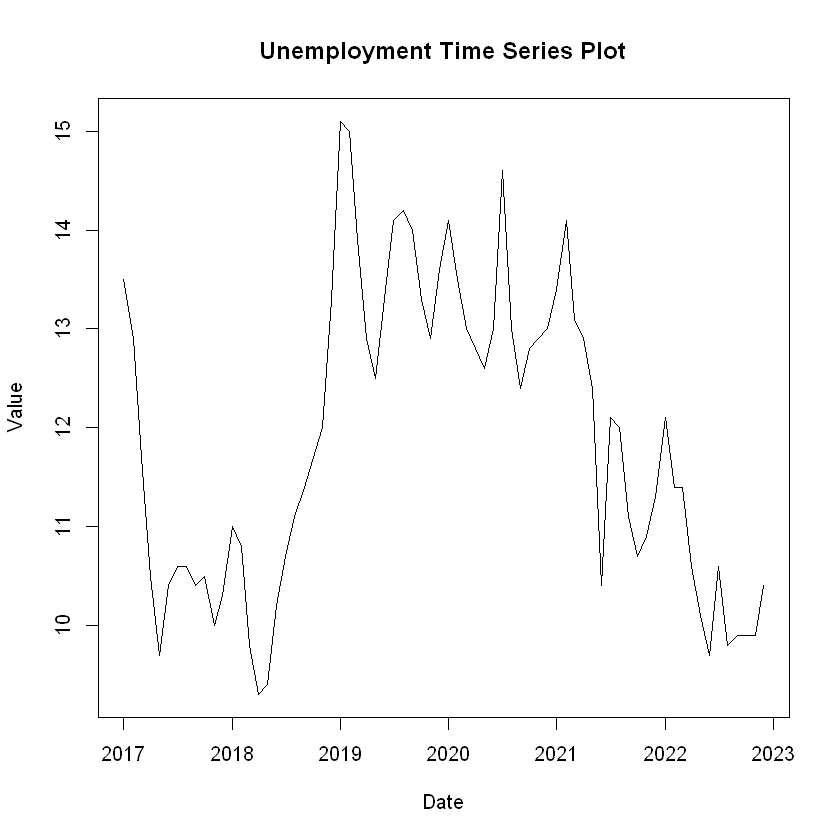

In [39]:
# Plotting the Unemployment Rate Data
plot(date_data, unem_data, type = "l", xlab = "Date", ylab = "Value", main = "Unemployment Time Series Plot")
#İşkur Search Volume Data
iskur_excel_data = "iskursearchvolume.csv"
searchvolumeiskur = fread(iskur_excel_data)
searchvolumeiskur$Date = as.Date(paste(searchvolumeiskur$Date, "-01", sep=""))
iskurdata = searchvolumeiskur$IskurSearchVolume

The correlation between İskur search volume data and unemployment rate data: 0.4012513

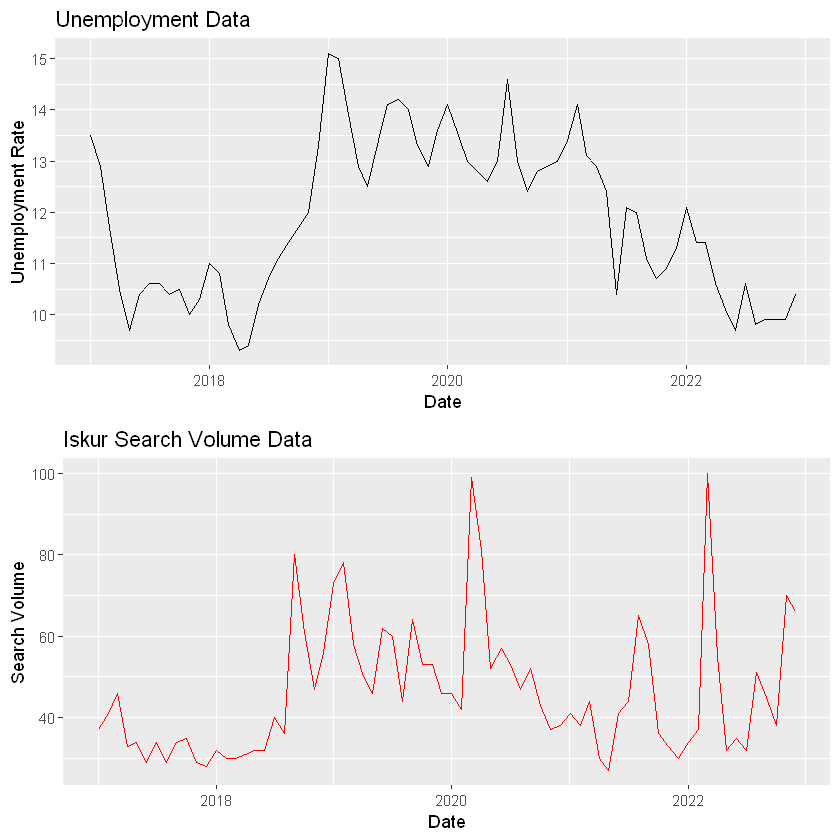

In [40]:
#Correlation Between İşkur Search Volume Data and Unemployment Rate Data
cat("The correlation between İskur search volume data and unemployment rate data:", cor(iskurdata ,unem_data))
plot1 <- ggplot(data, aes(x = date_data, y = unem_data)) + geom_line() + labs(title = "Unemployment Data", x = "Date", y = "Unemployment Rate")
plot2 <- ggplot(data, aes(x = date_data, y = iskurdata)) + geom_line(color = "red") +  labs(title = "Iskur Search Volume Data", x = "Date", y = "Search Volume")
grid.arrange(plot1, plot2, ncol = 1)

After the correlation between these data is calculated, it is found that they have a reasonable correlation as expected. When the plots are compared, it is seen that some of the fluctuations, movements, and jumps that occurred at the same time resemble each other. For instance, the decrease in both data at the beginning of the year 2019 and the fluctuations in the year 2022 look very similar. In addition to that, the fluctuations generally follow a similar pattern, especially in the years 2017, 2018, and 2022. This similarity shows us that there is a relation between these two data and also a positive correlation despite some differences.

2. Part 2 - Time Series Regression Analysis

   In the second part, to build a time series regression model for the unemployment rate, some data/independent variables that might be related or might explain some portion of the unemployment rate data are introduced. Before starting to build various models with the combination of these variables, the pairwise correlation between the unemployment data and other data that are going to be used as independent variables. The purpose of performing this step is to get an early idea of how the independent variables relate to the data and whether they are very irrelevant or very relevant beforehand. Then, the combination of these independent variables is tried to build a better model in terms of explaining the unemployment rate without violating simple linear regression assumptions.
   The independent variables used to model the unemployment rate are "Trend", "Seasonality (Monthly)", "Capacity Utilization Rate of the Manufacturing Industry", "The Total Number of Debit Card and Credit Card Transactions on Food", "İşkur Search Volume", "Exchange Rate (Dollar/TL)", "Consumer Confidence Index" and categorical Covid variable. To explain the reason for using these variables without going deeply, it is thought that in the cases where the capacity utilization rate of the manufacturing industry is low, a high unemployment rate may arise because blue-collar workers may become unemployed. It is not a certain relation but it might be useful in the modelling. For the expenditures on food, there might be a decrease in expenditure on food with the increase in the unemployment rate since the unemployed people will spend less. Thus, a negative correlation is anticipated. The İşkur Search Volume is already mentioned previously. As another variable, the exchange rate might also affect the unemployment rate. It can be put forward that as the exchange rates vary or increase, then local employers or business owners might think of downsizing which increases the unemployment rate. The other variables used are Consumer Confidence Index and Covid. Since the Covid-pandemic era witnessed lots of changes in all economic and business dynamics, it could be better to take into account those values separately. When we come to the last variable, Consumer Confidence Index is related to consumers'' behaviors and tendency to spend money. Even though it is a much more complicated relationship, it is expected that the consumer confidence index and unemployment rate have a negative correlation.

In [41]:
cor(unem_data, capacityutilization_data)
cor(unem_data, foodexpenditure_data)
cor(unem_data, exchangerate_data)
cor(unem_data, consumerconfidenceindex_data)


[1] -0.4656499

[1] -0.360133

[1] -0.2983875

[1] -0.1178071

The correlation between capacity utilization data and unemployment rate data: -0.465649

The correlation between food expenditure data and unemployment rate data: -0.360133

The correlation between exchange rate data and unemployment rate data: -0.298387

The correlation between consumer confidence index data and unemployment rate data: -0.117807

In [42]:
fit_trend <- lm(unem_data~trend,data = data)
summary(fit_trend)
fit_trend_seasonality <- lm(unem_data~trend+as.factor(data$month),data = data)
summary(fit_trend_seasonality)
fit_capacity <- lm(unem_data~capacityutilization_data,data = data)
summary(fit_capacity)
fit_foodexpenditure <- lm(unem_data~foodexpenditure_data,data = data)
summary(fit_foodexpenditure)
fit_exchangerate <- lm(unem_data~exchangerate_data,data = data)
summary(fit_exchangerate)
fit_cci <- lm(unem_data~consumerconfidenceindex_data,data = data)
summary(fit_cci)
fit_combined <- lm(unem_data~capacityutilization_data+data$trend+as.factor(data$month)+consumerconfidenceindex_data,data = data)
summary(fit_combined)
fit_combined2 <- lm(unem_data~exchangerate_data+data$trend+as.factor(data$month)+consumerconfidenceindex_data,data = data)
summary(fit_combined2)
fit_combined3 <- lm(unem_data~exchangerate_data+data$trend+as.factor(data$month)+foodexpenditure_data,data = data)
summary(fit_combined3)
fit_combined4 <- lm(unem_data~capacityutilization_data+data$trend+as.factor(data$month)+foodexpenditure_data,data = data)
summary(fit_combined4)


Call:
lm(formula = unem_data ~ trend, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.5967 -1.4067 -0.0381  1.1419  3.2152 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 11.918036   0.371042  32.120   <2e-16 ***
trend       -0.001331   0.008834  -0.151    0.881    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.558 on 70 degrees of freedom
Multiple R-squared:  0.0003243,	Adjusted R-squared:  -0.01396 
F-statistic: 0.02271 on 1 and 70 DF,  p-value: 0.8806



Call:
lm(formula = unem_data ~ trend + as.factor(data$month), data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-2.324 -1.201 -0.075  1.317  2.475 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             13.154484   0.689932  19.066   <2e-16 ***
trend                    0.001468   0.008906   0.165   0.8696    
as.factor(data$month)2  -0.251468   0.894224  -0.281   0.7795    
as.factor(data$month)3  -1.052937   0.894357  -1.177   0.2438    
as.factor(data$month)4  -1.704405   0.894578  -1.905   0.0616 .  
as.factor(data$month)5  -2.089206   0.894889  -2.335   0.0230 *  
as.factor(data$month)6  -2.024008   0.895287  -2.261   0.0275 *  
as.factor(data$month)7  -1.092143   0.895774  -1.219   0.2276    
as.factor(data$month)8  -1.426944   0.896350  -1.592   0.1167    
as.factor(data$month)9  -1.678413   0.897013  -1.871   0.0663 .  
as.factor(data$month)10 -1.729881   0.897765  -1.927   0.0588 .  
as.factor(data$month)11 -1.781349


Call:
lm(formula = unem_data ~ capacityutilization_data, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3890 -0.9283 -0.3315  0.9808  2.8307 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              29.24019    3.94917   7.404 2.28e-10 ***
capacityutilization_data -0.22810    0.05181  -4.402 3.76e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.379 on 70 degrees of freedom
Multiple R-squared:  0.2168,	Adjusted R-squared:  0.2056 
F-statistic: 19.38 on 1 and 70 DF,  p-value: 3.76e-05



Call:
lm(formula = unem_data ~ foodexpenditure_data, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.79101 -1.23682  0.04519  0.96705  2.95872 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.316e+01  4.353e-01   30.23  < 2e-16 ***
foodexpenditure_data -1.564e-08  4.844e-09   -3.23  0.00189 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.454 on 70 degrees of freedom
Multiple R-squared:  0.1297,	Adjusted R-squared:  0.1173 
F-statistic: 10.43 on 1 and 70 DF,  p-value: 0.001888



Call:
lm(formula = unem_data ~ exchangerate_data, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9545 -1.0713  0.1737  1.0907  2.9825 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       12.67659    0.35488  35.721   <2e-16 ***
exchangerate_data -0.10412    0.03981  -2.616   0.0109 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.487 on 70 degrees of freedom
Multiple R-squared:  0.08904,	Adjusted R-squared:  0.07602 
F-statistic: 6.842 on 1 and 70 DF,  p-value: 0.0109



Call:
lm(formula = unem_data ~ consumerconfidenceindex_data, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6218 -1.2517  0.0241  1.1694  3.1941 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  13.90053    2.05442   6.766 3.32e-09 ***
consumerconfidenceindex_data -0.02490    0.02508  -0.993    0.324    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.547 on 70 degrees of freedom
Multiple R-squared:  0.01388,	Adjusted R-squared:  -0.0002089 
F-statistic: 0.9852 on 1 and 70 DF,  p-value: 0.3243



Call:
lm(formula = unem_data ~ capacityutilization_data + data$trend + 
    as.factor(data$month) + consumerconfidenceindex_data, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2243 -0.8698 -0.2123  0.9308  2.2299 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  42.31310    5.12340   8.259 2.56e-11 ***
capacityutilization_data     -0.26226    0.04887  -5.366 1.53e-06 ***
data$trend                   -0.03353    0.01295  -2.590  0.01217 *  
as.factor(data$month)2       -0.36941    0.71436  -0.517  0.60708    
as.factor(data$month)3       -0.97598    0.71661  -1.362  0.17857    
as.factor(data$month)4       -2.20412    0.72060  -3.059  0.00338 ** 
as.factor(data$month)5       -2.46881    0.71800  -3.438  0.00110 ** 
as.factor(data$month)6       -2.08990    0.71553  -2.921  0.00500 ** 
as.factor(data$month)7       -0.92210    0.71762  -1.285  0.20401    
as.factor(data$month)8       -1.16379    0.7177


Call:
lm(formula = unem_data ~ exchangerate_data + data$trend + as.factor(data$month) + 
    consumerconfidenceindex_data, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8798 -0.6342  0.0268  0.7962  1.7372 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  27.76391    2.92861   9.480 2.56e-13 ***
exchangerate_data            -0.49219    0.05914  -8.322 2.01e-11 ***
data$trend                    0.04798    0.01388   3.457  0.00104 ** 
as.factor(data$month)2       -0.42324    0.58895  -0.719  0.47530    
as.factor(data$month)3       -0.84921    0.59064  -1.438  0.15596    
as.factor(data$month)4       -1.68609    0.58885  -2.863  0.00586 ** 
as.factor(data$month)5       -2.03229    0.58909  -3.450  0.00106 ** 
as.factor(data$month)6       -1.85309    0.58971  -3.142  0.00266 ** 
as.factor(data$month)7       -0.81561    0.59173  -1.378  0.17348    
as.factor(data$month)8       -1.14785    0.59151  -1.9


Call:
lm(formula = unem_data ~ exchangerate_data + data$trend + as.factor(data$month) + 
    foodexpenditure_data, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.92503 -0.78918  0.01475  0.60944  2.09193 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              1.394e+01  5.701e-01  24.449  < 2e-16 ***
exchangerate_data       -3.195e-01  8.724e-02  -3.663 0.000548 ***
data$trend               7.809e-02  1.416e-02   5.515 8.82e-07 ***
as.factor(data$month)2  -3.761e-01  6.813e-01  -0.552 0.583080    
as.factor(data$month)3  -9.496e-01  6.847e-01  -1.387 0.170857    
as.factor(data$month)4  -1.751e+00  6.817e-01  -2.569 0.012851 *  
as.factor(data$month)5  -2.162e+00  6.848e-01  -3.157 0.002548 ** 
as.factor(data$month)6  -1.917e+00  6.821e-01  -2.810 0.006779 ** 
as.factor(data$month)7  -8.829e-01  6.883e-01  -1.283 0.204797    
as.factor(data$month)8  -1.281e+00  6.836e-01  -1.874 0.066098 .  
as.factor(data$


Call:
lm(formula = unem_data ~ capacityutilization_data + data$trend + 
    as.factor(data$month) + foodexpenditure_data, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0026 -0.7669 -0.1030  0.6127  2.4413 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               2.645e+01  4.642e+00   5.697 4.49e-07 ***
capacityutilization_data -1.632e-01  6.178e-02  -2.642  0.01061 *  
data$trend                2.118e-02  1.250e-02   1.694  0.09565 .  
as.factor(data$month)2   -3.728e-01  7.147e-01  -0.522  0.60396    
as.factor(data$month)3   -9.246e-01  7.188e-01  -1.286  0.20352    
as.factor(data$month)4   -2.089e+00  7.224e-01  -2.892  0.00541 ** 
as.factor(data$month)5   -2.481e+00  7.183e-01  -3.453  0.00105 ** 
as.factor(data$month)6   -2.028e+00  7.169e-01  -2.829  0.00644 ** 
as.factor(data$month)7   -8.252e-01  7.219e-01  -1.143  0.25776    
as.factor(data$month)8   -1.217e+00  7.170e-01  -1.697  0.09518 .  
as.fact


Call:
lm(formula = unem_data ~ iskurdata + exchangerate_data + capacityutilization_data + 
    foodexpenditure_data + as.factor(data$month) + as.factor(data$covid) + 
    consumerconfidenceindex_data, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.45713 -0.57262 -0.01791  0.51391  1.50803 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   3.146e+01  4.478e+00   7.025 3.75e-09 ***
iskurdata                     2.234e-02  8.504e-03   2.628 0.011171 *  
exchangerate_data            -3.611e-01  5.736e-02  -6.296 5.70e-08 ***
capacityutilization_data     -6.308e-02  4.941e-02  -1.277 0.207205    
foodexpenditure_data          9.016e-09  7.512e-09   1.200 0.235276    
as.factor(data$month)2       -3.819e-01  4.803e-01  -0.795 0.430017    
as.factor(data$month)3       -1.564e+00  5.277e-01  -2.964 0.004510 ** 
as.factor(data$month)4       -2.039e+00  4.852e-01  -4.202 9.98e-05 ***
as.factor(data$mon


	Breusch-Godfrey test for serial correlation of order up to 40

data:  Residuals
LM test = 67.405, df = 40, p-value = 0.00431



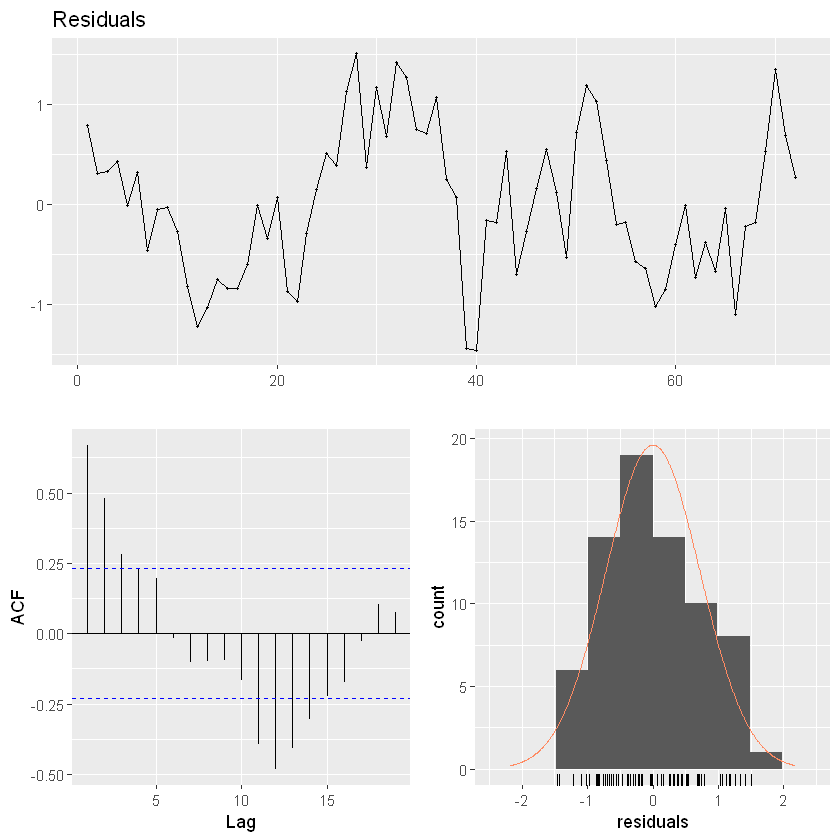

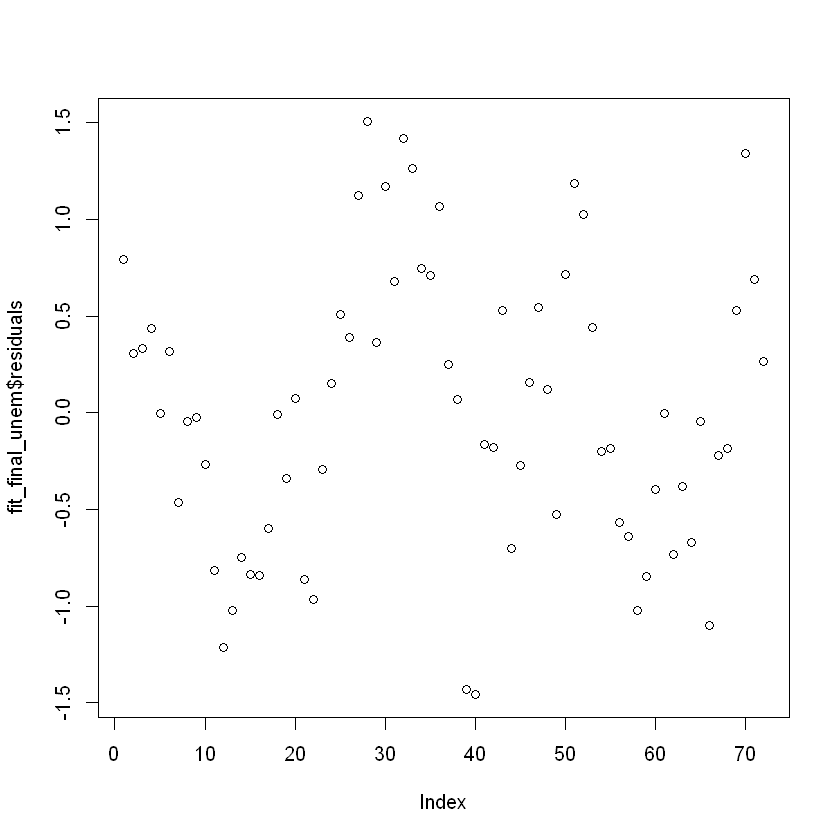

In [43]:
fit_final_unem <- lm(unem_data~iskurdata+exchangerate_data+capacityutilization_data+foodexpenditure_data+as.factor(data$month)+as.factor(data$covid)+consumerconfidenceindex_data,data = data)
summary(fit_final_unem)
checkresiduals(fit_final_unem,40)
plot(fit_final_unem$residuals)

In the final regression model built for the unemployment data, the independent variables "İşkur Search Volume", "Exchange Rate", "Capacity Utilization Rate of Manufacturing Industry", "Food Expenditure", "Seasonality (Monthly)", "Consumer Confidence Index", and "Covid" are used. Based on the results, the coefficients of some variables are significant. It can be stated that the exchange rate, covid, consumer confidence index and many of the seasonality variables are significant by looking at the p values. One of the other results of this model is that the R-squared value is 0.71 which is quite reasonable in terms explaining the variance of the original model. When the first models are built their R-squared values are very low compared to the final model. By introducing new variables and combining the existing ones, it is achieved to explain the unemployment rate with independent variables having significant coefficients which means that they are correlated with the target variable. When the residuals are checked, it can be seen that they have randomly distributed and their mean is around 0 which is a good sign for simple linear regression models. The model is not biased in other words. The autocorrelation between the residuals and its lagged values resides between the limits with a few exceptions. It can also be eliminated by introducing new variables or changing some of them but since there are lots of variables added to model, I left as it is. It seemed tolerable in that sense. As the general result of time series regression analysis, it can be said that the consumer confidence index and exchange rate are significant variables that can be used in modelling the unemployment rate. Furthermore, one more point can be discussed. The plot of residuals on the right bottom corner demonstrates that residuals are normally distributed with a mean approximately zero and it implies that the model we built is good at catching the data patterns and there is no biased term.

## Airline Expenditures Model
1. Part 1 - Data Manipulation and Visualization

In this model, it is thought that there might be a relationship between the total debit and credit card transactions on airlines and the vacations abroad. To examine whether there is a relation between the expenditures on airlines and vacations abroad, I looked at the keyword "yurt dışı tatil" on Google Trends and plotted its search volume data with the expenditure data on airlines.
Here is my research question and the keyword determined.

Research Question: Are the debit and credit card expenditures on airlines related to vacations abroad?

Keyword: Yurt Dışı Tatil

The correlation between Yurt Disi Tatili search volume data and total expenditure on airlines data: 0.5611278

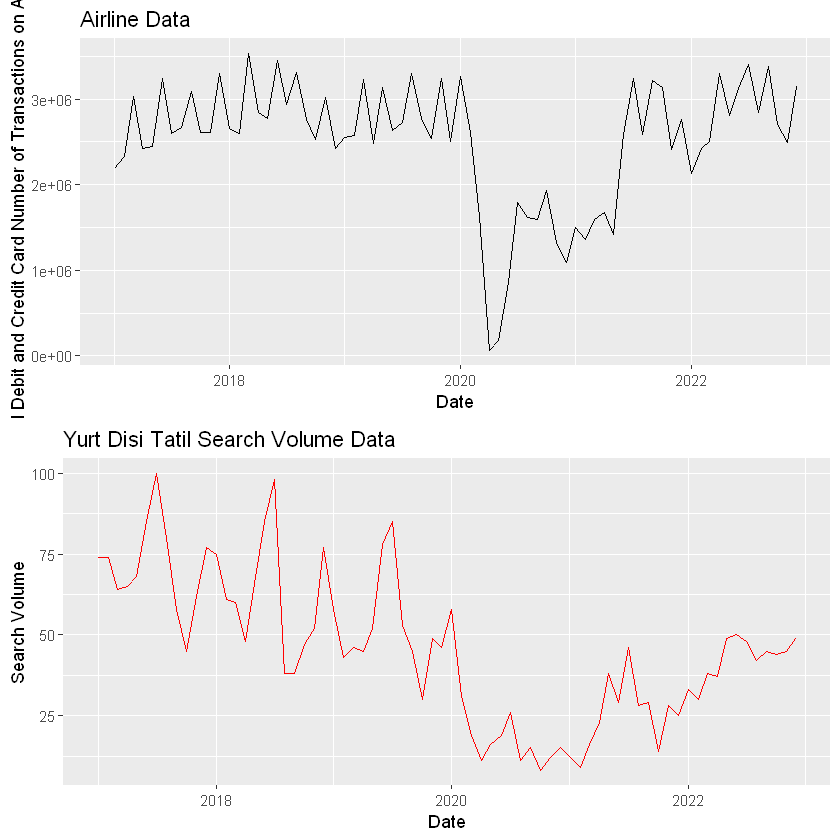

In [44]:
yurtdisitatil_excel_data = "yurtdisitatilsearchvolume.csv"
searchvolumeyurtdisitatil = fread(yurtdisitatil_excel_data)
searchvolumeyurtdisitatil$Date = as.Date(paste(searchvolumeyurtdisitatil$Date, "-01", sep=""))
yurtdisitatildata = searchvolumeyurtdisitatil$YurtdisiTatilSearchVolume
cat("The correlation between Yurt Disi Tatili search volume data and total expenditure on airlines data:",cor(yurtdisitatildata,airline_data))
plot1 <- ggplot(data, aes(x = date_data, y = airline_data)) + geom_line() + labs(title = "Airline Data", x = "Date", y = "Total Debit and Credit Card Number of Transactions on Airlines")
plot2 <- ggplot(data, aes(x = date_data, y = yurtdisitatildata)) + geom_line(color = "red") + labs(title = "Yurt Disi Tatil Search Volume Data", x = "Date", y = "Search Volume")
grid.arrange(plot1, plot2, ncol = 1)

Based on the graphs plotted, it is observed that the "Yurt Disi Tatil Search Volume" data seems to follow a very similar pattern to airline data. Although some of the jumps and fluctuations match well in the graphs such as the drop in 2020 and fluctuations in 2021, there is a decreasing trend between 2017-2020 in "Yurt Disi Tatil Search Volume" data which differs from the airline data. As a result, it can be said that vacations abroad searches are related to airline expenditures and affect it but it's not able to explain the airline expenditure data solely. As opposed to what is expected, it explains some portion of the airline expenditure data.

2. Part 2 - Time Series Regression Analysis

   In the second part, to find a time series regression model that fits well for the total credit card and debit card transactions on airlines, I employed independent variables: "Trend", "Seasonality (Monthly), "Visa Search Volume", "Yurt Dışı Tatil Search Volume" and categorical "Covid" variable. It is thought that whenever people go abroad, they might need a visa for it and it seems to be a more general case than the search volume of vacation abroad because not everyone goes on vacation when they buy an airplane ticket. 
It may also be due to other reasons such as work-related,or  family-related situations Again, the same steps are carried out in the time series regression modeling.
    .

In [45]:
cor(visadata,airline_data)
cor(visadata,yurtdisitatildata)


[1] 0.6147278

[1] 0.4478923

The correlation between visa search volume data and total debit and credit card transactions on airlines data: 0.614727

which is really high correlation as expected.

In [46]:
fit1 <- lm(airline_data~yurtdisitatildata,data = data)
summary(fit1)
fit2 <- lm(airline_data~visadata+as.factor(month)+trend+as.factor(covid)+yurtdisitatildata,data = data)
summary(fit2)


Call:
lm(formula = airline_data ~ yurtdisitatildata, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1822838  -410776   104866   393647  1195138 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1686117     162493  10.377 8.40e-16 ***
yurtdisitatildata    18126       3196   5.672 2.94e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 616200 on 70 degrees of freedom
Multiple R-squared:  0.3149,	Adjusted R-squared:  0.3051 
F-statistic: 32.17 on 1 and 70 DF,  p-value: 2.942e-07



Call:
lm(formula = airline_data ~ visadata + as.factor(month) + trend + 
    as.factor(covid) + yurtdisitatildata, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-901998 -267470   19894  268552  639687 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1927267     444731   4.334 6.15e-05 ***
visadata              10519       7384   1.425   0.1598    
as.factor(month)2     12296     232223   0.053   0.9580    
as.factor(month)3    452084     229268   1.972   0.0536 .  
as.factor(month)4    -53969     236843  -0.228   0.8206    
as.factor(month)5     -4959     228107  -0.022   0.9827    
as.factor(month)6    255632     231441   1.105   0.2741    
as.factor(month)7    385249     248505   1.550   0.1267    
as.factor(month)8    373264     229073   1.629   0.1088    
as.factor(month)9    491750     233124   2.109   0.0394 *  
as.factor(month)10   171161     244195   0.701   0.4863    
as.factor(month)11  -180578     319651  -0


Call:
lm(formula = airline_data ~ visadata + as.factor(month) + as.factor(covid) + 
    trend, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-911146 -260093   24748  256146  646660 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1974462.6   393361.5   5.019 5.41e-06 ***
visadata              11281.1     6576.1   1.715   0.0917 .  
as.factor(month)2      5403.6   228441.0   0.024   0.9812    
as.factor(month)3    445061.0   225414.6   1.974   0.0532 .  
as.factor(month)4    -66766.4   228562.1  -0.292   0.7713    
as.factor(month)5      -307.2   225352.4  -0.001   0.9989    
as.factor(month)6    266560.8   224821.1   1.186   0.2407    
as.factor(month)7    408959.9   225148.4   1.816   0.0746 .  
as.factor(month)8    369057.9   226469.9   1.630   0.1087    
as.factor(month)9    486261.0   230017.6   2.114   0.0389 *  
as.factor(month)10   150599.6   226037.9   0.666   0.5079    
as.factor(month)11  -208456.1   294288


	Breusch-Godfrey test for serial correlation of order up to 18

data:  Residuals
LM test = 26.316, df = 18, p-value = 0.09274



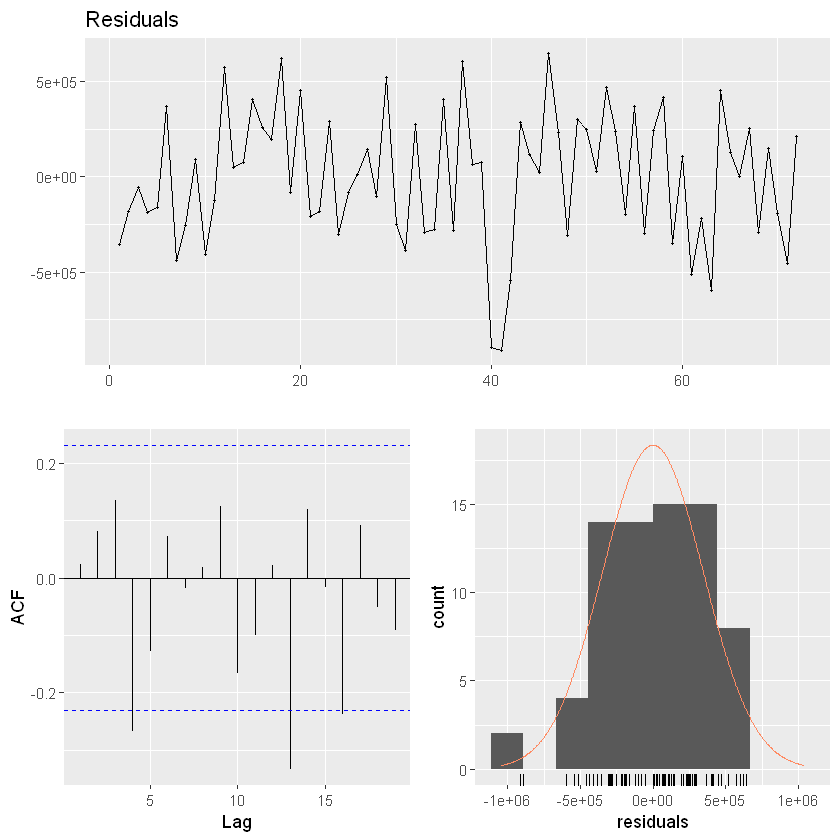

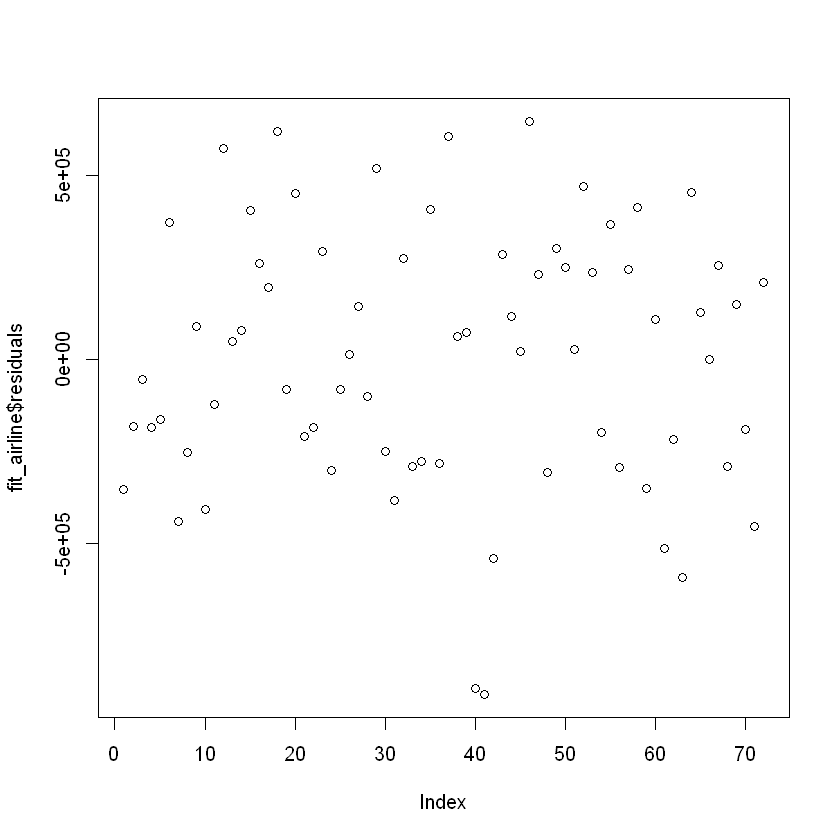

In [47]:
fit_airline <- lm(airline_data~visadata+as.factor(month)+as.factor(covid)+trend,data = data)
summary(fit_airline)
checkresiduals(fit_airline)
plot(fit_airline$residuals)

In the final regression model built for the total debit and credit card transactions on airline data, the independent variables "Visa Search Volume", "Seasonality (Monthly)", "Covid" and "Trend" are used. By looking the R-squared value which is 0.72, it can be said that the predictor variables explain the variance of the dependent variable to some extent. Since there is collinearity between Visa Search Volume data and Yurt Disi Tatil data, in the regression model selected for the airline expenditures model, Yurt Disi Tatil data is excluded to avoid multicollinearity problems. To put it another way, to observe the effect of the predictor Visa Search Volume, the Yurt Disi Tatil Search Volume is not added. If we look at the p values, it can reached that only the coefficient of covid variable is significant. Although there is high correlation between visa data and airline data, the coefficent of visa variable is not significant that much. It has low significance. The F statistic value larger than the critical value in this model indicates the statistically significance of regression model. On the residuals side, it can be said that residuals do not follow any specific pattern and their mean is located near to 0. One of the residuals observed at the beginning of Covid time, is very high but apart from that residuals have desired properties. When the autocorrelation between residuals and their lagged values is evaluated, it is achieved that the only lags that has  autocorrelation higher than the limit are the 4th and 13th lag. However, they are a little beyond the limit so that it can be ignored. Moreover, the residual plot looks like normally distributed which does not violate the simple linear regression settings. Overall, the model built seems to be reasonable enough to explain the target variable so that I did not add any other variable.

## Total Newly Established Firms Model
1. Part 1 - Data Manipulation and Visualization

In this model, it is considered that entrepreneurship support initiatives or such incentives would affect the total number of newly established firms and new entrepreneurs.

Research Question: Can entrepreneurial grants be the driving force behind new entrepreneurs and newly established firms?

Keyword: Girişimci Desteği

The correlation between Girisimci Destegi search volume data and total newly established firms data: 0.7298033

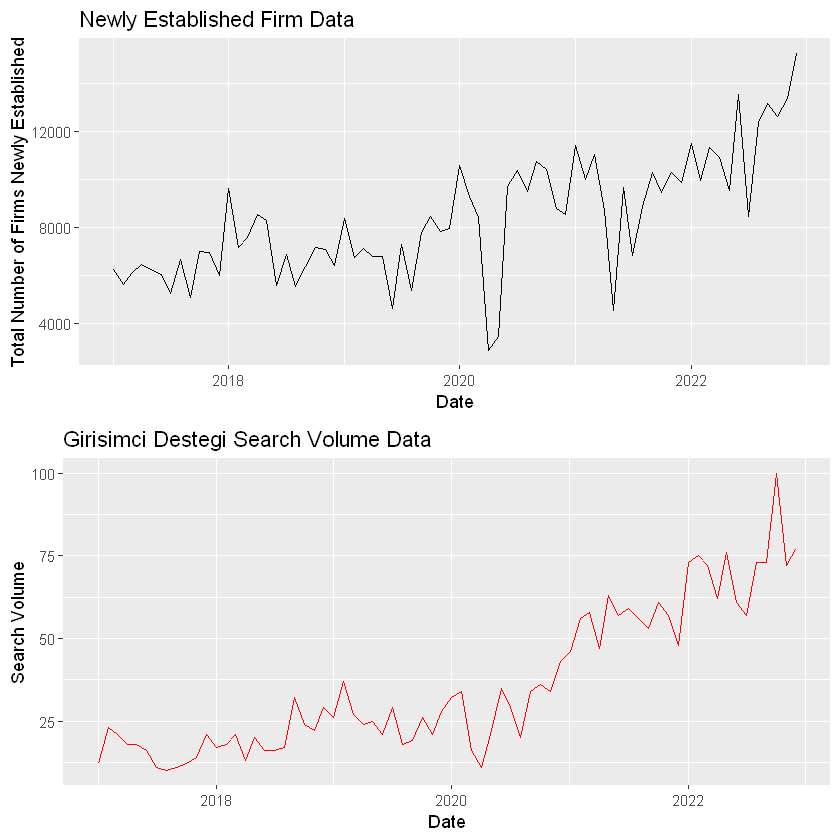

In [48]:
girisimcidestegi_excel_data = "girisimcidestegisearchvolume.csv"
searchvolumegirisimcidestegi = fread(girisimcidestegi_excel_data)
searchvolumegirisimcidestegi$Date = as.Date(paste(searchvolumegirisimcidestegi$Date, "-01", sep=""))
girisimcidata = searchvolumegirisimcidestegi$GirisimciDestegiSearchVolume
cat("The correlation between Girisimci Destegi search volume data and total newly established firms data:",cor(girisimcidata ,newfirm_data))
plot1 <- ggplot(data, aes(x = date_data, y = newfirm_data)) + geom_line() + labs(title = "Newly Established Firm Data", x = "Date", y = "Total Number of Firms Newly Established")
plot2 <- ggplot(data, aes(x = date_data, y = girisimcidata)) + geom_line(color = "red") + labs(title = "Girisimci Destegi Search Volume Data", x = "Date", y = "Search Volume")
grid.arrange(plot1, plot2, ncol = 1)

Based on the correlation between the data, and the pattern on the graphs, it can be said that total number of newly established firms and entrepreneurial grants are significantly related. It can be seen that the general pattern of the graphs match and also the jumps and downs in 2020 are similar to each other. Other than that, the significant (high) up and downs in 2022 in the newly established firms graph do not match with the entrepreneurial grant search volume data but it can be considered as an extreme case and it can be ignored while interpreting the relation between entrepreneurial grant and newly established firm data since the covid period takes place in 2022. Therefore, it can be deduced that those two data are closely related.

2. Part 2 - Time Series Regression Analysis

   In the second part, I used independent variables: "Trend", "Seasonality (Monthly), "Exchange Rate", Girisimci Destegi Search Volume", "Consumer Confidence Index" and categorical "Covid" variables. I thought that the Consumer Confidence Index might have an impact on newly established firms since it somehow represents the consumer's tendency to spend money or invest in something. When the Consumer Confidence Index is low, it is expected that newly established firms are lower. Other than that, I also considered the exchange rate as one of the independent variables because today the idea of ​​​​establishing a new enterprise can be interpreted as an international expansion. Therefore, the exchange rate might affect the entrepreneurs' decisions. Again, the same steps are carried out in the time series regression modeling.

In [49]:
cor(exchangerate_data,newfirm_data)
cor(consumerconfidenceindex_data,newfirm_data)

[1] 0.7362331

[1] -0.5179813

The correlation between exchange rate data and total newly established firms data: 0.736233

The correlation betweeconsumer confidence indexre data antotal newly established firmste data: -517983117807

In [50]:
fit3_1 <- lm(newfirm_data~`trend`,data = data)
summary(fit3_1)
fit3_2 <- lm(newfirm_data~trend+as.factor(month)+girisimcidata,data = data)
summary(fit3_2)
fit3_3 <- lm(newfirm_data~trend+as.factor(month)+girisimcidata+exchangerate_data,data = data)
summary(fit3_3)



Call:
lm(formula = newfirm_data ~ trend, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-5775.5  -696.3   126.5   963.0  3877.4 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5237.110    417.652  12.539  < 2e-16 ***
trend         85.409      9.944   8.589  1.5e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1754 on 70 degrees of freedom
Multiple R-squared:  0.5131,	Adjusted R-squared:  0.5062 
F-statistic: 73.78 on 1 and 70 DF,  p-value: 1.502e-12



Call:
lm(formula = newfirm_data ~ trend + as.factor(month) + girisimcidata, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3914.9  -847.3  -111.1   876.6  3375.8 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         6717.31     724.74   9.269 4.79e-13 ***
trend                 42.53      20.92   2.033 0.046649 *  
as.factor(month)2  -1827.86     934.88  -1.955 0.055387 .  
as.factor(month)3  -1175.15     929.14  -1.265 0.211009    
as.factor(month)4  -2140.21     943.01  -2.270 0.026969 *  
as.factor(month)5  -3451.54     929.84  -3.712 0.000463 ***
as.factor(month)6  -1642.30     934.79  -1.757 0.084219 .  
as.factor(month)7  -2327.81     939.52  -2.478 0.016159 *  
as.factor(month)8  -1777.78     946.84  -1.878 0.065466 .  
as.factor(month)9  -1171.88     936.86  -1.251 0.216009    
as.factor(month)10 -1242.57     932.69  -1.332 0.187989    
as.factor(month)11 -1108.56     944.08  -1.174 0.245104    
as.factor(month)


Call:
lm(formula = newfirm_data ~ trend + as.factor(month) + girisimcidata + 
    exchangerate_data, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-4217.9  -716.9   -22.8   863.5  3310.7 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         6667.59     705.71   9.448 2.89e-13 ***
trend                 26.78      21.75   1.231 0.223301    
as.factor(month)2  -1640.18     914.36  -1.794 0.078150 .  
as.factor(month)3  -1169.13     904.22  -1.293 0.201239    
as.factor(month)4  -2352.47     923.48  -2.547 0.013576 *  
as.factor(month)5  -3504.19     905.26  -3.871 0.000282 ***
as.factor(month)6  -1804.19     913.11  -1.976 0.053017 .  
as.factor(month)7  -2514.16     918.79  -2.736 0.008268 ** 
as.factor(month)8  -2043.06     930.40  -2.196 0.032184 *  
as.factor(month)9  -1344.12     915.56  -1.468 0.147579    
as.factor(month)10 -1274.14     907.80  -1.404 0.165879    
as.factor(month)11 -1339.94     925.60  -1.448 0.153194 


Call:
lm(formula = newfirm_data ~ trend + as.factor(month) + exchangerate_data + 
    consumerconfidenceindex_data + girisimcidata + data$year, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-4199.7  -525.2    42.3   682.3  2959.1 

Coefficients: (1 not defined because of singularities)
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  -6049.217   4375.700  -1.382 0.172320    
trend                           65.017     24.212   2.685 0.009515 ** 
as.factor(month)2            -1464.635    860.671  -1.702 0.094351 .  
as.factor(month)3            -1383.299    852.194  -1.623 0.110159    
as.factor(month)4            -2515.351    868.931  -2.895 0.005400 ** 
as.factor(month)5            -3527.860    850.089  -4.150 0.000114 ***
as.factor(month)6            -1985.664    859.642  -2.310 0.024605 *  
as.factor(month)7            -2857.869    870.638  -3.283 0.001776 ** 
as.factor(month)8            -2392.193    881.69


	Breusch-Godfrey test for serial correlation of order up to 20

data:  Residuals
LM test = 31.215, df = 20, p-value = 0.05242



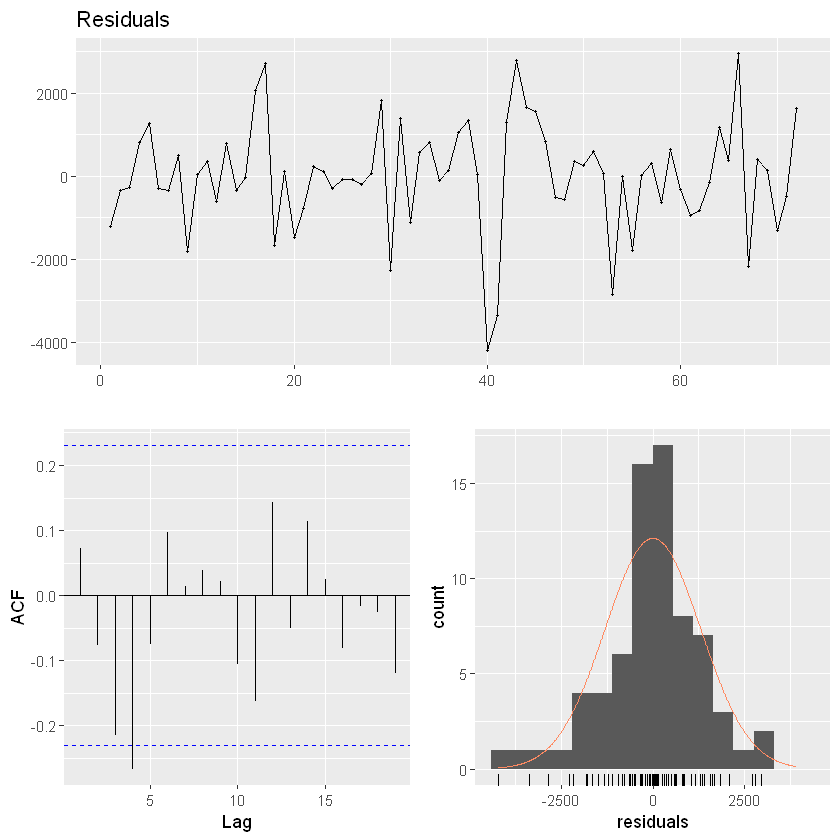

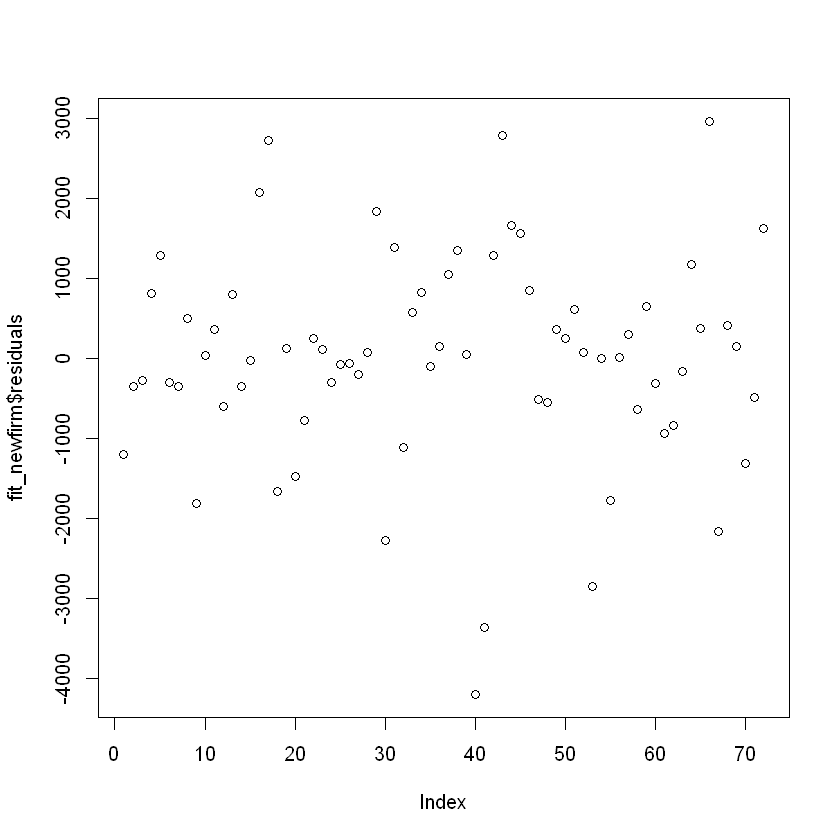

In [51]:
fit_newfirm <- lm(newfirm_data~trend+as.factor(month)+exchangerate_data+consumerconfidenceindex_data+girisimcidata+data$year,data = data)
summary(fit_newfirm)
checkresiduals(fit_newfirm)
plot(fit_newfirm$residuals)

In the final regression model of newly established firms, the predictors "Trend", "Seasonality (Monthly)", "Exchange Rate", "Consumer Confidence Index", and "Entrepreneurial Grant" are used. The R-squared value of the model is equal to 0.65 which might be evaluated as a good result to predict the variance of the target (newly established firms) variables. When the first models are built, it is seen that R-squared values are very low like 0.13 and 0.21. However, after adding the consumer confidence index variable, a drastic change occurred in the R-squared value. Based on this, it is achieved that although it seems to be a complicated relationship, the consumer confidence index is closely related to newly established firm data. Without diving deep into this relationship, it can be said that when there is a more comfortable atmosphere that facilitates consumer spending and makes them feel more secure, business owners or entrepreneurs are affected in a good way because of the higher demand for products and services. On the other side, if we look at the p values, it can be said that the exchange rate and consumer confidence index have a little significant coefficient that may indicate these variables are able to explain some portion of the change in the target variable. However, as opposed to the expectations, the entrepreneurial grant variable does not have a significant coefficient. It is a sign that not every variable highly correlated with the target variable would be effective in explaining the target variable. Therefore, a high correlation does not mean a good predictor for the regression model every time. According to the residual plot, it can be seen that there are some outliers but when they are excluded, the residuals have low variance that does not change over time and their mean is close to 0 which is a desired outcome in regression models. Apart from that, the autocorrelations between the residuals and their lagged values are very low and are within the desired range except for the 4th lag. It is a little bit beyond the range so it does not pose a problem. With this information and observing that the residuals are normally distributed, this model seems to perform fine in explaining the target variable. 

# Conclusion
In a nutshell, three different time series data are selected from CBRT and their correlation/relation with some other time series data is analyzed. In order to build a time regression model for each CBRT data, relevant data are added to the models as independent variables. Besides, seasonality and trend variables are included in the models. After analyzing various regression models for each data, one of the regression models presenting high R-squared value, low p values and low residual values (errors) is selected. In addition, the variance and mean of the residuals are evaluated and, autocorrelation between the lagged values of the residuals. As a result, three regression models whose residuals are not autocorrelated and have a mean zero are built. The independent variables used in these models are found to be related to the target variable and some of them have significant coefficients which means there is a relationship between them and the target variable by checking the p-values.
